In [1]:
import torch
from torchvision.datasets import CIFAR100
from PIL import Image
import numpy as no
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader 
from torchmetrics import Accuracy 
import torchvision.transforms.v2 as v2
import torch.nn as nn
from torch import optim
from torch.optim.lr_scheduler import StepLR
from tqdm import tqdm
from IPython.display import clear_output
from PIL import Image
import pandas as pd
import numpy as np
from datetime import date


In [2]:
pip install torchsummary 

Note: you may need to restart the kernel to use updated packages.


In [3]:
train_transforms = v2.Compose([
    
    v2.ToImage(), 
    v2.ToDtype(torch.float32, scale=True), 
    v2.Resize(( 32, 32)) 
    
]) 

In [4]:
train_dataset = CIFAR100('/kaggle/input/database/cifar100', 
                         train=True, 
                         transform=train_transforms 
                        ) 
 

In [5]:
#вычмслим среднее и стандартное отклонение всего дата сета. 
train_dataset.data

array([[[[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [195, 205, 193],
         [212, 224, 204],
         [182, 194, 167]],

        [[255, 255, 255],
         [254, 254, 254],
         [254, 254, 254],
         ...,
         [170, 176, 150],
         [161, 168, 130],
         [146, 154, 113]],

        [[255, 255, 255],
         [254, 254, 254],
         [255, 255, 255],
         ...,
         [189, 199, 169],
         [166, 178, 130],
         [121, 133,  87]],

        ...,

        [[148, 185,  79],
         [142, 182,  57],
         [140, 179,  60],
         ...,
         [ 30,  17,   1],
         [ 65,  62,  15],
         [ 76,  77,  20]],

        [[122, 157,  66],
         [120, 155,  58],
         [126, 160,  71],
         ...,
         [ 22,  16,   3],
         [ 97, 112,  56],
         [141, 161,  87]],

        [[ 87, 122,  41],
         [ 88, 122,  39],
         [101, 134,  56],
         ...,
         [ 34,  36,  10],
        

In [6]:
train_dataset[0][0].shape

/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


torch.Size([3, 32, 32])

In [7]:
test_dataset = CIFAR100('/kaggle/input/database/cifar100', 
                         train=False, 
                        transform=train_transforms 
                        ) 
test_dataset 

Dataset CIFAR100
    Number of datapoints: 10000
    Root location: /kaggle/input/database/cifar100
    Split: Test
    StandardTransform
Transform: Compose(
                 ToImage()
                 ToDtype(scale=True)
                 Resize(size=[32, 32], interpolation=InterpolationMode.BILINEAR, antialias=warn)
           )

In [8]:
img = train_dataset[0][0] 
print(img.shape) 
print(img.mode()) 
 

torch.Size([3, 32, 32])
torch.return_types.mode(
values=tensor([[1.0000, 0.9961, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         0.4588, 0.2078, 0.3569, 0.1137, 0.4275, 0.3451, 0.2588, 0.4784, 0.6706,
         0.3098, 0.5059, 0.2980, 0.2824, 0.2863, 0.2980, 0.3569, 0.5882, 0.6510,
         0.5882, 0.6314, 0.5490, 0.4941, 0.4314],
        [1.0000, 0.9961, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         0.9922, 0.0588, 0.2980, 0.2078, 0.5098, 0.1686, 0.2745, 0.2745, 0.5686,
         0.2039, 0.6824, 0.6118, 0.8392, 0.2471, 0.2549, 0.7725, 0.6000, 0.8000,
         0.5412, 0.5098, 0.4902, 0.4392, 0.4784],
        [1.0000, 0.9961, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.9961,
         0.9961, 0.1373, 0.0431, 0.1451, 0.1294, 0.3765, 0.3294, 0.1843, 0.6078,
         0.0314, 0.3255, 0.0588, 0.4902, 0.0392, 0.1922, 0.1294, 0.1098, 0.2431,
         0.3843, 0.3804, 0.2588, 0.1765, 0.1686]]),
indices=tensor([[ 1, 11,  0,  2,  2,  0,  0,  0,  6, 26, 14, 28

In [9]:
train_loader = DataLoader(train_dataset, 
                         batch_size=100,
                         shuffle=True, 
                         ) 

In [10]:
valid_loader = DataLoader(test_dataset, 
                         batch_size=100,
                         shuffle=True, 
                         ) 

In [11]:
#Зададим девайс для обучения        
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# dev = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(device)
try:
    print(torch.cuda.get_device_name())
except:
    print('GPU нету!')
        
    
def train(model: nn.Module,
         loader: DataLoader,
         loss_fn,
         metric) -> tuple[float, float]: 
    
    '''ф-я проводит обучение модели. 
    возвращает ошибку на трейновом датасете'''
    
    model.train()
    total_loss = 0
    total_metric = 0
    for x, y in tqdm(loader, desc="Train"):
        x, y = x.to(device), y.to(device)
        
        optimizer.zero_grad() 
    
        output = model(x) 
    
        loss = loss_fn(output, y) 
        total_loss += loss.item()
        
        loss.backward() 
    
        optimizer.step()
        
        total_metric +=  metric(output.detach(), y).item()
        
    total_loss /= len(loader)
    total_metric /= len(loader) 
    
    return total_loss, total_metric

@torch.inference_mode() 
def valid(model: nn.Module,
         loader: DataLoader,
         loss_fn,
         metric) -> tuple[float, float] :
    
    '''Ф-я расчитывает ф-ю ошибки и метрику на валидационной выборке'''
    model.eval() 
    
    total_loss = 0
    total_metric = 0
    
    for x, y in tqdm(loader, desc="Evaluation"):
        x, y = x.to(device), y.to(device)
        
        output = model(x) 
        
        loss = loss_fn(output, y) 
        
        total_loss += loss.item()
        
        total_metric += metric(output, y).item() 
        
        
    total_loss /= len(loader)
    total_metric /= len(loader) 
    return total_loss, total_metric


def plot_stats(
    train_loss: tuple,
    valid_loss: tuple, 
    train_metric: tuple, 
    valid_metric: tuple, 
    title: str,
    metric_name: str ) :
    '''Ф-я отрисовывает ошибку и метрику на тестовой и трейновой датасетах.
    '''
    plt.figure(figsize=(8, 5))
    plt.title(f'{title} loss') 
    plt.plot(train_loss, label='Train loss') 
    plt.plot(valid_loss, label='Valid loss') 
    
    plt.legend() 
    plt.grid() 
    
    plt.figure(figsize=(8, 5))
    plt.title(f'{title} {metric_name}')
    plt.plot(train_metric, label=f'Train {metric_name}') 
    plt.plot(valid_metric, label=f'Valid {metric_name}') 
    plt.legend() 
    
    plt.grid() 
    
    plt.show() 
    
    
#Функция обучения и валидации на всех эпохах
def train_test_cycle(model: nn.Module,
                    num_epochs: int, 
                    loss_fn, 
                    train_loader: DataLoader, 
                    valid_loader: DataLoader,
                    metric,
                    metric_name: str,
                    title: str,
                    scheduler):
    '''Ф-я проводит для каждой эпох обучение на трейновой выборке, валидацию для валидной выборки
    и отрисовку графиков. '''
    
    train_loss_history, train_metric_history = [], []
    valid_loss_history, valid_metric_history = [], []
    
    
    for epoch in range(num_epochs): 
        train_loss, train_metric = train(model,
                          train_loader, 
                          loss_fn,
                          metric)
        
        valid_loss, valid_metric = valid(model, 
                           valid_loader, 
                           loss_fn, 
                           metric) 
        
        train_loss_history.append(train_loss) 
        valid_loss_history.append(valid_loss) 
        
        train_metric_history.append(train_metric) 
        valid_metric_history.append(valid_metric)
                
        clear_output()
        
        plot_stats(train_loss_history, 
                  valid_loss_history, 
                  train_metric_history, 
                  valid_metric_history, 
                  title,
                  metric_name) 
        
        scheduler.step() 
        print(f'Valid Loss: {valid_loss}') 
        print(f'Valid {metric_name}: {valid_metric}') 

cuda:0
Tesla T4


In [12]:
class ResidualBlock(nn.Module):
    
    def __init__(self,
                in_channels, 
                out_channels, 
                stride, 
                downsample=None) :
        super(ResidualBlock, self).__init__() 
        
        self.downsample = downsample
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, 
                      out_channels, 
                      kernel_size=3, 
                      padding=1,
                      stride=stride),
            nn.BatchNorm2d(out_channels), 
            nn.ReLU() ) 
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(out_channels, 
                      out_channels, 
                      kernel_size=3,
                      padding=1,
                      stride=stride) , 
            nn. BatchNorm2d(out_channels),) 
            
        self.relu = nn.ReLU() 
        
    def forward(self, x) :
        residual = x
        #1 свёртки в блоке
        out = self.conv1(x) 
        out = self.conv2(out) 
        
        if self.downsample :
            residual = self.downsample(x) 
            
        out = out + residual 
        out = self.relu(out) 
        
        return out 


class FirstCIFAR(nn.Module) :
    def __init__(self) :
        super().__init__() 
        #3x32x32
        self.im_size, self.pooling_size = 32, 2
        self.in_channels = 64 
        #print('init0', self.im_size, self.in_channels) 
        #self.maxpool = self.custom_maxpool(kernel_size =2) 
        
        #print('init 1 ' ,self.im_size, self.in_channels) 
        self.conv1 = nn.Sequential(
            nn.Conv2d(3,
                     64, 
                     kernel_size = 5,
                     padding =2,
                     stride=1), 
            nn.BatchNorm2d(64) , 
            nn. ReLU() , 
            self.custom_maxpool(2), 
            nn.Dropout2d(p=0.5) 
            ) 
        #64x16x16
        #print('init 2', self.im_size, self.in_channels ) 
     
        
        self.layer1 = self.make_layer(
            in_chan=self.in_channels,
            out_chan=128,
            stride=1) 
        #print('init 3', self.im_size, self.in_channels) 
        self.maxpool_1 = self.custom_maxpool(2) 
        
        self.layer2 = self.make_layer(
            in_chan=self.in_channels,
            out_chan=256,
            stride=1)  
        #print('layer2', self.im_size, self.in_channels) 
        self.maxpool_2 = self.custom_maxpool(2) 
        print('layer 2', self.im_size, self. in_channels) 
        #256*4
        self.layer3 = self. make_layer(in_chan=self.in_channels, 
                                        out_chan=512, 
                                        stride=1) 
        self.maxpool_3 = self. custom_maxpool(2) 
        print('layer 3', self. im_size, self. in_channels) 
        
        self.fc = nn.Linear(self.im_size*self.im_size * self.in_channels,
                            100)
                        
        
        self.dropout = nn.Dropout(p=0.5) 
                             
        self.flatten = nn.Flatten() 
     
    def custom_maxpool(self, 
                kernel_size, 
                ) :
        
        
        self.im_size = int(self.im_size / kernel_size) 
        return nn.MaxPool2d(kernel_size=kernel_size) 
            
    def make_layer(self,
                   in_chan, 
                   out_chan, 
                   stride=1 ):
        downsample = None
        if in_chan !=  out_chan :
            downsample = nn.Sequential(
                                nn.Conv2d(in_channels=in_chan, 
                                         out_channels=out_chan,
                                         kernel_size=1,
                                         ), 
                                nn.BatchNorm2d(out_chan) 
                                ) 
            
        
        layer = ResidualBlock(in_channels=in_chan, 
                              out_channels=out_chan,
                              stride=stride, 
                              downsample=downsample) 
        
        self.in_channels = out_chan 
        return layer 
        
        
    def forward(self,  x) :
        #3x32x32
        out = self.conv1(x) #64x16x16
        
        out = self.layer1(out) #128x16x16
        
        out = self.maxpool_1(out) #128x8x8
        
        out = self.dropout(out) 
        out = self.layer2(out) 
        out = self.maxpool_2(out)
        out = self.dropout(out) 
        
        out = self.layer3(out) 
        out = self.maxpool_3(out) 
        out = self. dropout(out) 
        out = self.flatten(out) 
        out = self.fc(out) 
                           
                           
        return out

In [13]:
from torchsummary import summary 
fmodel = FirstCIFAR().to(device)
print('init model') 
summary(fmodel, (3, 32, 32)) 

layer 2 4 256
layer 3 2 512
init model
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           4,864
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
         MaxPool2d-4           [-1, 64, 16, 16]               0
         Dropout2d-5           [-1, 64, 16, 16]               0
            Conv2d-6          [-1, 128, 16, 16]          73,856
       BatchNorm2d-7          [-1, 128, 16, 16]             256
              ReLU-8          [-1, 128, 16, 16]               0
            Conv2d-9          [-1, 128, 16, 16]         147,584
      BatchNorm2d-10          [-1, 128, 16, 16]             256
           Conv2d-11          [-1, 128, 16, 16]           8,320
      BatchNorm2d-12          [-1, 128, 16, 16]             256
             ReLU-13          [-1, 128, 16, 16]               0


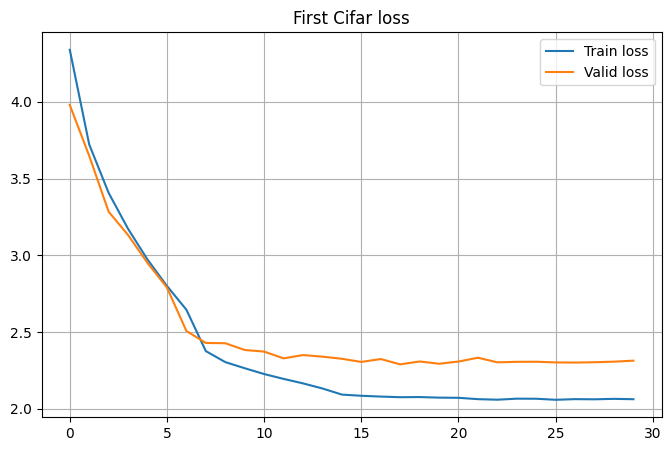

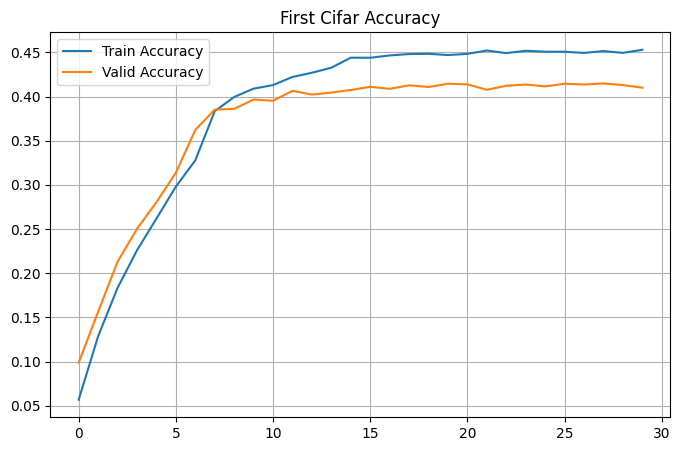

Valid Loss: 2.314219118356705
Valid Accuracy: 0.41009999945759773


In [14]:
num_epochs = 30
#зададим метрику precision
metric = Accuracy(task='multiclass', num_classes=100).to(device)
metric_name = 'Accuracy'
#model = FourthModel()
model = FirstCIFAR() 
#model = model.to(device)
if torch.cuda.is_available():
    if torch.cuda.device_count() > 1:
        print(f'Имеется {torch.cuda.device_count()} GPU') 
        model = nn.DataParallel(model) 
model.to(device) 
title = 'First Cifar'
optimizer = optim.Adam(model.parameters(), lr=1e-3) 
scheduler = StepLR(optimizer, step_size=7) 
loss_fn = nn.CrossEntropyLoss()
train_test_cycle(model,
                 num_epochs,
                 loss_fn, 
                 train_loader,
                 valid_loader,
                 metric,
                 metric_name,
                 title, 
                 scheduler
                )

In [15]:
torch.save(model.state_dict(), f'{title}_{date.today()}.pth')

In [16]:
dummy_input = torch.randn(1, 3, 32, 32) 
model.to(torch.device('cpu')) 
torch.onnx.export(model.module,
                 dummy_input, 
                 f'{title}_{date.today()}.onnx',
                 verbose=True )

Exported graph: graph(%input.1 : Float(1, 3, 32, 32, strides=[3072, 1024, 32, 1], requires_grad=0, device=cpu),
      %fc.weight : Float(100, 2048, strides=[2048, 1], requires_grad=1, device=cpu),
      %fc.bias : Float(100, strides=[1], requires_grad=1, device=cpu),
      %onnx::Conv_110 : Float(64, 3, 5, 5, strides=[75, 25, 5, 1], requires_grad=0, device=cpu),
      %onnx::Conv_111 : Float(64, strides=[1], requires_grad=0, device=cpu),
      %onnx::Conv_113 : Float(128, 64, 3, 3, strides=[576, 9, 3, 1], requires_grad=0, device=cpu),
      %onnx::Conv_114 : Float(128, strides=[1], requires_grad=0, device=cpu),
      %onnx::Conv_116 : Float(128, 128, 3, 3, strides=[1152, 9, 3, 1], requires_grad=0, device=cpu),
      %onnx::Conv_117 : Float(128, strides=[1], requires_grad=0, device=cpu),
      %onnx::Conv_119 : Float(128, 64, 1, 1, strides=[64, 1, 1, 1], requires_grad=0, device=cpu),
      %onnx::Conv_120 : Float(128, strides=[1], requires_grad=0, device=cpu),
      %onnx::Conv_122 : Fl